# Notebook 03: Reproduction of paper results

In this notebook, we try to reproduce results from the CATHODE paper (https://arxiv.org/pdf/2109.00546.pdf).

## Result 01: Training and validation loss for the MAF (Masked Autoregressive Flow) from the CATHODE method

In [1]:
import pandas as pd
import numpy as np
import os

# base directory of the repository
basedir = os.environ['ADMLWORKDIR']
result_dir = os.path.join(basedir, 'notebooks', 'CATHODE_models')

train_loss = np.load(os.path.join(result_dir, 'my_ANODE_model_train_losses.npy'))
val_loss = np.load(os.path.join(result_dir, 'my_ANODE_model_val_losses.npy'))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

train_avg_loss = moving_average(train_loss[1:], 5)
val_avg_loss = moving_average(val_loss[1:], 5)

In [2]:
from quickstats.plots import General1DPlot
from quickstats.plots.template import create_transform

dfs = {
    'train_loss': pd.DataFrame({
        'x': np.arange(1, train_loss.shape[0]),
        'y': train_loss[1:]
    }),
    'val_loss': pd.DataFrame({
        'x': np.arange(1, val_loss.shape[0]),
        'y': val_loss[1:]
    }),
    'avg_train_loss': pd.DataFrame({
        'x': np.arange(3, train_loss.shape[0] - 2),
        'y': train_avg_loss
    }),
    'avg_val_loss': pd.DataFrame({
        'x': np.arange(3, val_loss.shape[0] - 2),
        'y': val_avg_loss
    })
}

styles_map = {
    'train_loss': {
        'linestyle' : ":",
        'color': "blue"
    },
    'val_loss': {
        'linestyle' : ":",
        'color': "orange"
    },
    'avg_train_loss': {
        'linestyle' : "-",
        'color': "blue"
    },
    'avg_val_loss': {
        'linestyle' : "-",
        'color': "orange"
    }
}
label_map = {
    'train_loss': 'Training (per epoch value)',
    'val_loss': 'Validation (per epoch value)',
    'avg_train_loss': 'Training (5 epoch average)',
    'avg_val_loss': 'Validation (5 epoch average)',
}
plotter = General1DPlot(dfs, styles_map=styles_map, label_map=label_map)

Text(0.1, 0.9, 'CATHODE')

<Figure size 640x480 with 0 Axes>

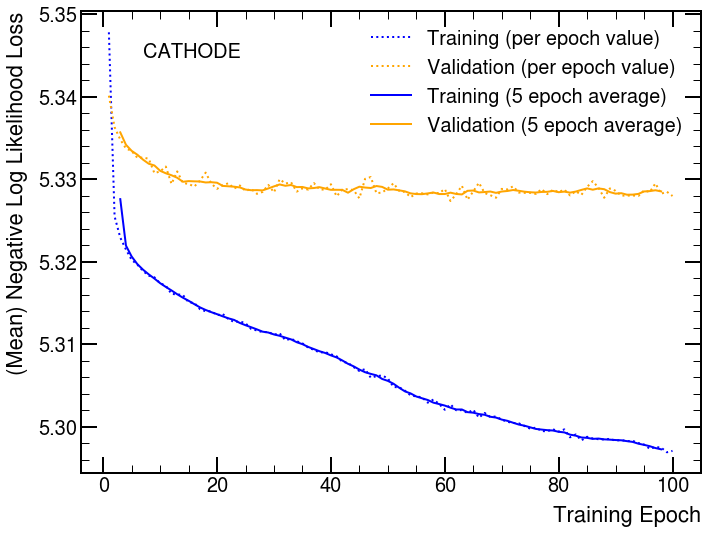

In [38]:
ax = plotter.draw('x', 'y', xlabel='Training Epoch', ylabel='(Mean) Negative Log Likelihood Loss', ypad=0)
ax.text(0.1, 0.9, 'CATHODE', fontsize=20, transform=create_transform('axis', 'axis'))

- The training losses improve faster and are more stable than the ones reported in the paper
- The validation losses plateaus at values similar to the ones reported in the paper

## Result 02: Comparison of features between background and synthetic samples

- For the moment, the $m_{j1}$, $\delta m_{j}$, $\tau_{21, j1}$ and $\tau_{21, j2}$ variables are the standardized version.

In [21]:
test = np.load(os.path.join(basedir, 'preprocessed_data', 'innerdata_train.npy'))

In [48]:
x_val = np.load(os.path.join(result_dir, 'X_validation.npy'))
y_val = np.load(os.path.join(result_dir, 'y_validation.npy'))
## unstandardize data (does not work)
#reference_data = np.load(os.path.join(basedir, 'preprocessed_data', 'innerdata_train.npy'))[:, 1:-1]
#mean_vals = np.mean(reference_data, axis=0)
#std_vals = np.std(reference_data, axis=0)
#x_val[:, 1:5] = x_val[:, 1:5] * std_vals + mean_vals

data_array = x_val[y_val == 1]
sample_array = x_val[y_val == 0]

sig_array = data_array[data_array[:,-1]==1]
bkg_array = data_array[data_array[:,-1]==0]

In [49]:
from quickstats.plots import VariableDistributionPlot
import matplotlib.pyplot as plt

columns = ['mjj', 'mj1', 'delta_mj', 'tau21_j1', 'tau21_j2']
dfs = {
    'sig': pd.DataFrame(sig_array[:, :-2], columns=columns),
    'bkg': pd.DataFrame(bkg_array[:, :-2], columns=columns),
    'sample': pd.DataFrame(sample_array[:, :-2], columns=columns),
}
label_map = {
    'sig': 'Signal',
    'bkg': 'Background',
    'sample': 'Samples'
}
column_map = {
    'mjj': r'$m_{jj}$',
    'mj1': r'$m_{j1}$ (std)',
    'delta_mj': r'$\delta m_{j}$ (std)',
    'tau21_j1': r'$\tau_{21, j1}$ (std)',
    'tau21_j2': r'$\tau_{21, j2}$ (std)'
}
units = {
    'mjj': 'TeV'
}
styles = {
    'legend': {
        'loc': (0.68, 0.8)
    }
}
plot_options = {
    'bkg':{
        'samples': ['bkg'],
        'styles': {
            'histtype': 'stepfilled',
            'color': 'cadetblue',
            'alpha': 0.8
        }
    },
    'sample': {
        'samples': ['sample'],
        'styles': {
            'histtype': 'step',
            'color': 'maroon'
        }
    }
}
plotter = VariableDistributionPlot(dfs, plot_options=plot_options, label_map=label_map, styles=styles)

[INFO] Using deduced bin range (3.300, 3.700)


<Figure size 640x480 with 0 Axes>

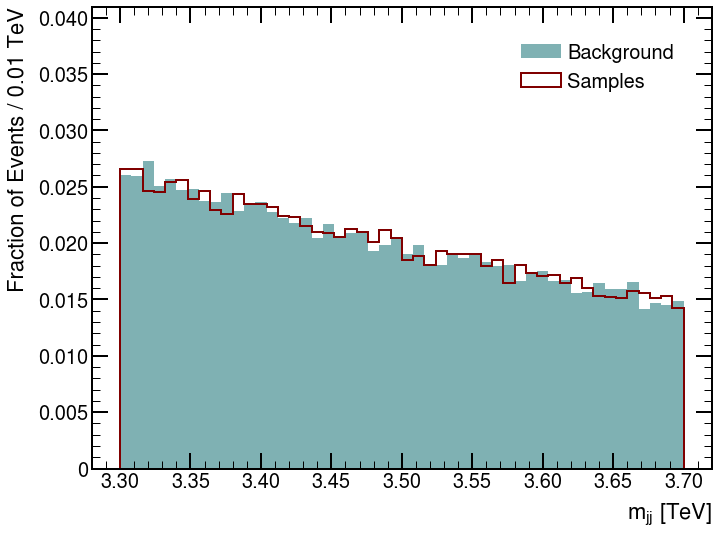

[INFO] Using deduced bin range (-4.139, 11.429)


<Figure size 640x480 with 0 Axes>

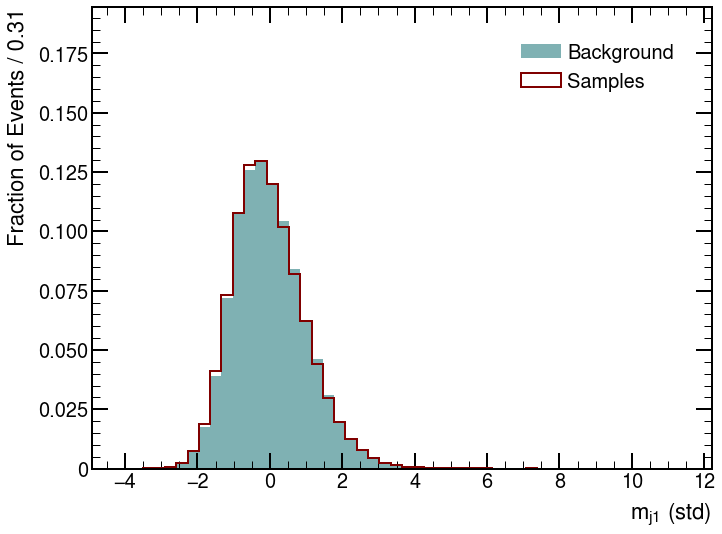

[INFO] Using deduced bin range (-9.937, 4.763)


<Figure size 640x480 with 0 Axes>

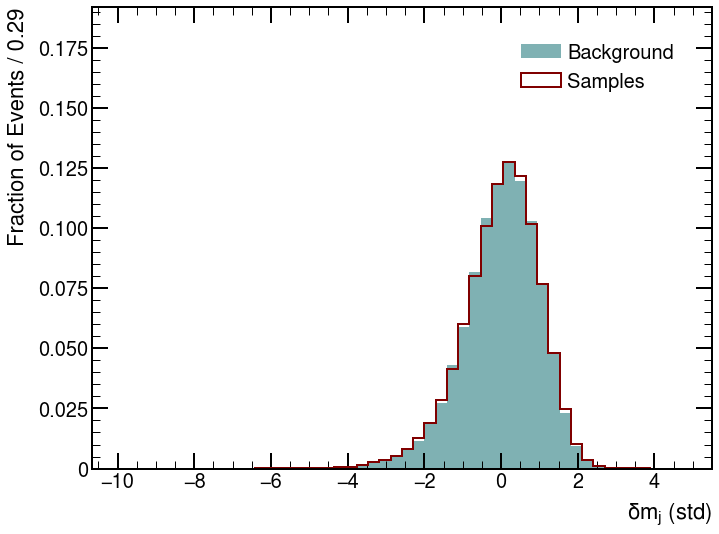

[INFO] Using deduced bin range (-4.795, 8.514)


<Figure size 640x480 with 0 Axes>

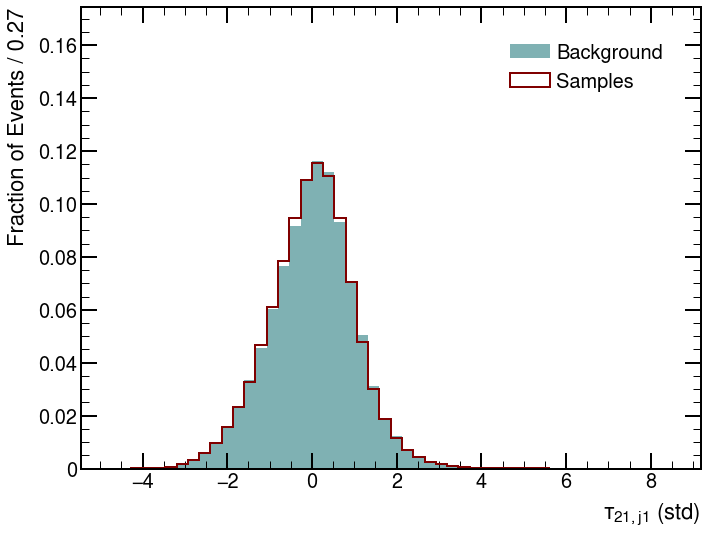

[INFO] Using deduced bin range (-5.317, 7.827)


<Figure size 640x480 with 0 Axes>

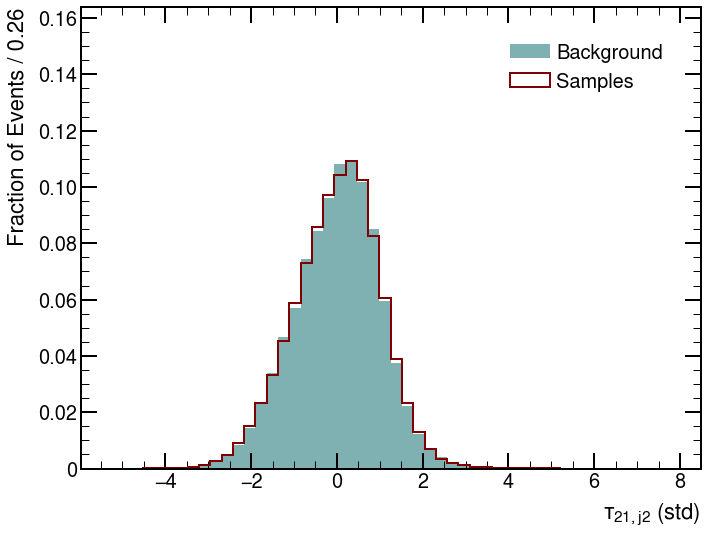

In [50]:
for column in column_map:
    plotter.draw(column, bins=50, targets=['bkg', 'sample'],
                 xlabel=column_map.get(column, column),
                 unit=units.get(column, None))
    plt.show()

- Reasonable agreement of $m_{jj}$ with paper
- Problem with unstandardizing other variables, will investigate

## Result 03: Training and validation loss (accuracy) of classifier

In [2]:
import torch
import glob
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# load losses
train_loss = np.load(os.path.join(result_dir, "loss_matris.npy"))[0]
val_loss = np.load(os.path.join(result_dir, "val_loss_matris.npy"))[0]

# derive accuracy
X_train = np.load(os.path.join(result_dir, "X_train.npy"))
y_train = X_train[:, -2]
X_test = np.load(os.path.join(result_dir, "X_validation.npy"))
y_test = X_test[:, -2]

model_files = glob.glob(os.path.join(result_dir, f"model_run0_ep*"))
train_accuracy = np.zeros(len(model_files))
val_accuracy = np.zeros(len(model_files))
for model_file in model_files:
    i = int(os.path.basename(model_file).replace('model_run0_ep', ''))
    model = torch.load(model_file, map_location=device)
    binary_prediction = model.predict(X_train[:,1:5]).flatten()>=0.5
    tp = np.sum(np.logical_and(binary_prediction, y_train==1))
    tn = np.sum(np.logical_and(~binary_prediction, y_train==0))
    train_accuracy[i] = (tp+tn)/binary_prediction.shape[0]
    binary_prediction = model.predict(X_test[:,1:5]).flatten()>=0.5
    tp = np.sum(np.logical_and(binary_prediction, y_test==1))
    tn = np.sum(np.logical_and(~binary_prediction, y_test==0))
    val_accuracy[i] = (tp+tn)/binary_prediction.shape[0]

In [3]:
train_avg_loss = moving_average(train_loss[1:], 5)
val_avg_loss = moving_average(val_loss[1:], 5)
train_avg_accuracy = moving_average(train_accuracy[1:], 5)
val_avg_accuracy = moving_average(val_accuracy[1:], 5)

In [7]:
from matplotlib.lines import Line2D
from quickstats.plots import TwoAxis1DPlot
from quickstats.plots.template import create_transform

dfs = {
    'train_loss': pd.DataFrame({
        'x': np.arange(1, train_loss.shape[0]),
        'y': train_loss[1:]
    }),
    'val_loss': pd.DataFrame({
        'x': np.arange(1, val_loss.shape[0]),
        'y': val_loss[1:]
    }),
    'avg_train_loss': pd.DataFrame({
        'x': np.arange(3, train_loss.shape[0] - 2),
        'y': train_avg_loss
    }),
    'avg_val_loss': pd.DataFrame({
        'x': np.arange(3, val_loss.shape[0] - 2),
        'y': val_avg_loss
    }),
    'train_accuracy': pd.DataFrame({
        'x': np.arange(1, train_accuracy.shape[0]),
        'y': train_accuracy[1:]
    }),
    'val_accuracy': pd.DataFrame({
        'x': np.arange(1, val_accuracy.shape[0]),
        'y': val_accuracy[1:]
    }),
    'avg_train_accuracy': pd.DataFrame({
        'x': np.arange(3, train_accuracy.shape[0] - 2),
        'y': train_avg_accuracy
    }),
    'avg_val_accuracy': pd.DataFrame({
        'x': np.arange(3, val_accuracy.shape[0] - 2),
        'y': val_avg_accuracy
    })    
    
}

styles_map = {
    'train_loss': {
        'linestyle' : ":",
        'color': "blue"
    },
    'val_loss': {
        'linestyle' : ":",
        'color': "orange"
    },
    'avg_train_loss': {
        'linestyle' : "-",
        'color': "blue"
    },
    'avg_val_loss': {
        'linestyle' : "-",
        'color': "orange"
    },
    'train_accuracy': {
        'linestyle' : ":",
        'color': "purple"
    },
    'val_accuracy': {
        'linestyle' : ":",
        'color': "red"
    },
    'avg_train_accuracy': {
        'linestyle' : "-",
        'color': "purple"
    },
    'avg_val_accuracy': {
        'linestyle' : "-",
        'color': "red"
    }    
}
label_map = {
    'train_loss': None,
    'val_loss': None,
    'train_accuracy': None,
    'val_accuracy': None, 
    'avg_train_loss': 'Training Loss',
    'avg_val_loss': 'Validation Loss',
    'avg_train_accuracy': 'Training Accuracy',
    'avg_val_accuracy': 'Validation Accuracy',
}

styles = {
    'legend': {
        'loc': (0.1, 0.85),
        'ncol': 3,
        'fontsize': 15
    }
}
plotter = TwoAxis1DPlot(dfs, styles_map=styles_map, label_map=label_map, styles=styles)

<Figure size 640x480 with 0 Axes>

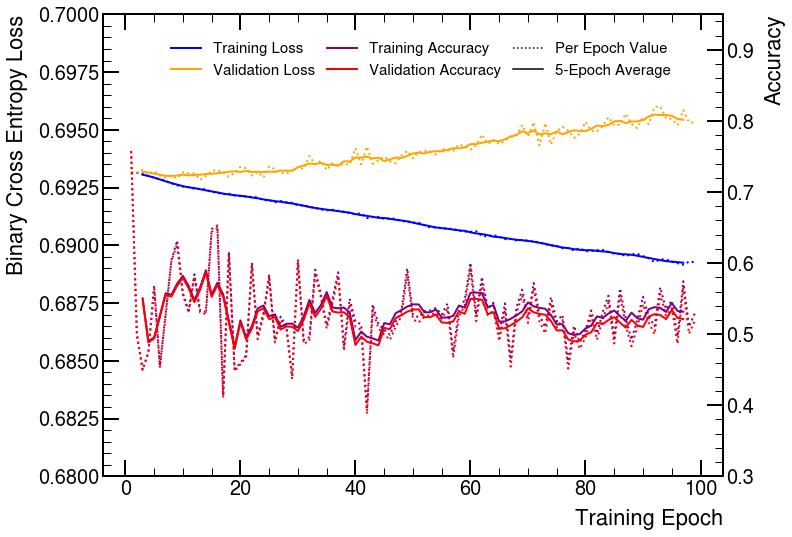

In [13]:
ax1, ax2 = plotter.draw('x', 'y',
                        targets_first=['train_loss', 'val_loss', 'avg_train_loss', 'avg_val_loss'],
                        targets_second=['train_accuracy', 'val_accuracy', 'avg_train_accuracy', 'avg_val_accuracy'],
                        xlabel='Training Epoch',
                        ylabel_first='Binary Cross Entropy Loss', ylabel_second='Accuracy',
                        ymin_first=0.68,
                        ymax_first=0.7,
                        ymin_second=0.3,
                        ymax_second=0.95)
per_epoch_line = Line2D([0], [0], linestyle=":", color="black")
epoch_avg_line = Line2D([0], [0], linestyle="-", color="black")
handles, labels = plotter.get_legend_handles_labels()
handles = handles + [per_epoch_line, epoch_avg_line]
labels = labels + ['Per Epoch Value', '5-Epoch Average']
ax1.legend(handles, labels, **plotter.styles['legend'])

- General trend looks similar to paper
- Training and validation loss more stable than paper

(btw it looks to me the model is overtrained since very early epochs?)

## Results 04: Signal Efficiency vs Background Rejection (Significance Improvement)

In [11]:
from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d

from evaluation_utils import load_predictions, tprs_fprs_sics, minumum_validation_loss_ensemble

save_dirs = {}
methods = ['CATHODE', 'ANODE', 'CWoLa', 'idealized_AD', 'supervised']
for method in methods:
    save_dirs[method] = os.path.join(basedir, 'notebooks', f'{method}_models')

def get_eval_data(outdir, n_ensemble_epochs=10, extra_signal=False, sic_range=(0, 20)):
    X_test, y_test, predictions, val_losses = load_predictions(outdir, outdir, extra_signal=extra_signal)
    if predictions.shape[1] == 1: ## check if ensembling done already
        min_val_loss_predictions = predictions
    else:
        min_val_loss_predictions = minumum_validation_loss_ensemble(
            predictions, val_losses, n_epochs=n_ensemble_epochs)
    tprs, fprs, sics = tprs_fprs_sics(min_val_loss_predictions, y_test, X_test)
    eval_data = get_median_predictions(tprs, fprs, sics, np.zeros(len(tprs)))
    return eval_data

def get_median_predictions(tprs, fprs, sics, pick_epochs):
    max_min_tpr = 0.
    min_max_tpr = 1.
    for tpr in tprs.values():
        if min(tpr) > max_min_tpr:
            max_min_tpr = min(tpr)
        if max(tpr) < min_max_tpr:
            min_max_tpr = max(tpr)
    tprs_manual = np.linspace(max_min_tpr, min_max_tpr, 1000)
    roc_interpol = []
    sic_interpol = []
    for j in range(len(pick_epochs)):
        roc_function = interp1d(tprs[j, pick_epochs[j]],
                                1/fprs[j, pick_epochs[j]])
        sic_function = interp1d(tprs[j, pick_epochs[j]],
                                tprs[j, pick_epochs[j]] / (fprs[j, pick_epochs[j]])**(0.5))
        roc_interpol.append(roc_function(tprs_manual))
        sic_interpol.append(sic_function(tprs_manual))
    roc_median = np.median(np.stack(roc_interpol), axis=0)
    sic_median = np.median(np.stack(sic_interpol), axis=0)
    median_predictions = {
        'tpr': tprs_manual,
        'roc': roc_median,
        'sic': sic_median        
    }
    return median_predictions

def get_ANODE_eval_data(outdir, extra_signal=False):
    preds = np.load(os.path.join(outdir, "preds_matris.npy"))
    labels = np.load(os.path.join(outdir, "sig_labels.npy"))
    if extra_signal:
        preds_extrasig = np.load(os.path.join(outdir, "preds_matris_extrasig.npy"))

    # removing nans and infs
    nan_mask = np.logical_and(~np.isnan(preds), ~np.isinf(preds))
    preds = preds[:,:,nan_mask[0,0,:]]
    labels = labels[nan_mask[0,0,:]]
    if extra_signal:
        nan_mask = np.logical_and(~np.isnan(preds_extrasig), ~np.isinf(preds_extrasig))
        preds_extrasig = preds_extrasig[:,:,nan_mask[0,0,:]]

    if extra_signal:
        preds_combined = np.concatenate((preds, preds_extrasig), axis=-1)
        labels_combined = np.concatenate((labels, np.ones(preds_extrasig.shape[-1])))
    else:
        preds_combined = preds
        labels_combined = labels

    tprs, fprs, sics = tprs_fprs_sics(preds_combined, np.ones(preds_combined.shape[-1]), labels_combined.reshape(-1,1))
    eval_data = get_median_predictions(tprs, fprs, sics, np.zeros(len(tprs)))
    return eval_data

eval_data = {}
for method in methods:
    if method == 'ANODE':
        eval_data[method] = pd.DataFrame(get_ANODE_eval_data(save_dirs[method]))
    else:
        eval_data[method] = pd.DataFrame(get_eval_data(save_dirs[method]))
        
eval_data['random'] = pd.DataFrame({
        'tpr': np.linspace(0.0001, 1, 300),
        'roc': 1 / np.linspace(0.0001, 1, 300),
        'sic': np.linspace(0.0001, 1, 300) / np.linspace(0.0001, 1, 300)**(0.5)
})

In [12]:
from quickstats.plots import General1DPlot

styles_map = {
    'CATHODE': {
        'color': '#ff00ff'
    },
    'ANODE': {
        'color': '#0000ff'
    },
    'CWoLa': {
        'color': '#ffa500'
    },
    'idealized_AD': {
        'color': '#323639'
    },
    'supervised': {
        'color': '#008000'
    },
    'random': {
        'color': 'k',
        'linestyle': ':'
    }
}
plotter = General1DPlot(eval_data, styles_map=styles_map)

<AxesSubplot: xlabel='Signal Efficiency (True Positive Rate)', ylabel='Rejection (1/False Positive Rate)'>

<Figure size 640x480 with 0 Axes>

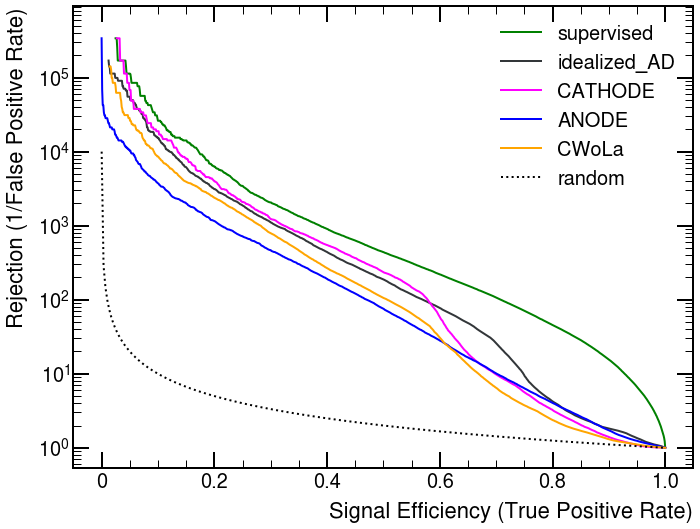

In [14]:
plotter.draw('tpr', 'roc', logy=True, xlabel='Signal Efficiency (True Positive Rate)',
             ylabel='Rejection (1/False Positive Rate)',
             targets=['supervised', 'idealized_AD', 'CATHODE', 'ANODE', 'CWoLa', 'random'])

<AxesSubplot: xlabel='Signal Efficiency (True Positive Rate)', ylabel='Significance Improvement'>

<Figure size 640x480 with 0 Axes>

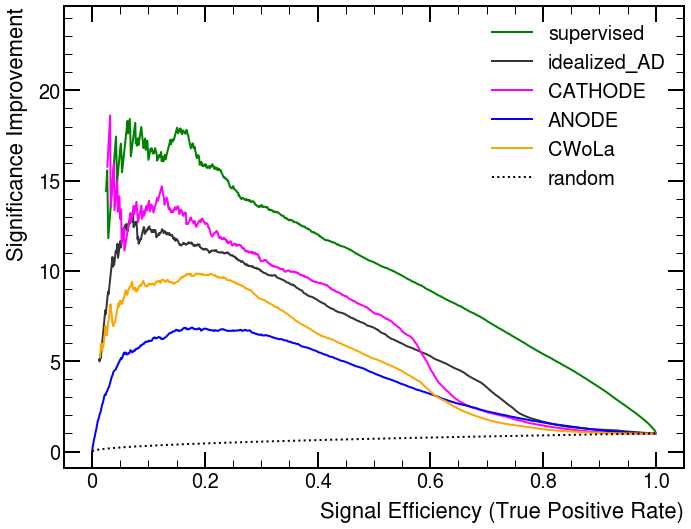

In [17]:
plotter.draw('tpr', 'sic', xlabel='Signal Efficiency (True Positive Rate)',
             ylabel='Significance Improvement',
             targets=['supervised', 'idealized_AD', 'CATHODE', 'ANODE', 'CWoLa', 'random'],
             ypad=0.2)